#### Judul : Ekstraksi Ciri Audio
#### Nama : Muhammad Ridho Pratama

##### Tujuan : Menganalisis Suara Dalam Domain Waktu dan Frekuensi

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import wavfile
from scipy.fft import fft, fftfreq, ifft
import pandas as pd
import sklearn


In [2]:
def load_wav(filepath):
    Sample_Rate, samples = wavfile.read(filepath)
    T = len(samples)/Sample_Rate
    time = np.linspace(0, T, len(samples))
    return time, samples, Sample_Rate 

def onelist(data):
    n = 0
    leftdata, rightdata = [], []
    for i in data:
        for j in i:
            if n == 0:
                leftdata.append(j)
                n = 1
                continue
            if n == 1:
                rightdata.append(j)
                n = 0
                continue
    return leftdata, rightdata

def fourier_transform(dataY, SR):
    Mag, frek = [], []
    for i in dataY:
        y_freq = fft(i); freq = fftfreq(len(i), (1/SR))
        y_freq_oneside = np.abs(y_freq[:len(i)//2]); freq_positif = np.abs(freq[:len(i)//2])
        Mag.append(y_freq_oneside); frek.append(freq_positif)
    return Mag, frek

def framing(Data, interval, step): # Interval harus > step, namun jangan sampai lebih 
    DataWindow = []
    for i in range(0, len(Data), step):
        DataWindow.append(Data[i:i+interval])
    return DataWindow


def findpeaks(dataY, dataX, threshold):
    peaks, index = [], []
    dataY = [i for i in dataY]
    for i in dataY:
        if i > threshold:
            peaks.append(i)
            index.append(dataY.index(i))
    peaks_pos = [dataX[j] for j in index]
    return peaks_pos, peaks, index

def sound_energy(data, interval, step):
    energy = np.array([sum(np.abs(data[i:i+interval])**2) for i in range (0, len(data), step)])
    normalized_energy = energy/len(energy)
    return energy, normalized_energy

def zoom(x, index_0, index_t):
    dataX = x[index_0:index_t]
    #dataY = y[index_0:index_t]
    return dataX#, dataY

def mapping(data, minVal, maxVal):
    dataMax = np.max(data)
    dataMin = np.min(data)
    outVal = np.array([minVal + ((i-dataMin)/(dataMax-dataMin))*(maxVal - minVal) for i in data])
    return outVal

def entropy(E_subframe, E_shortframe):
    n = int(len(E_subframe)/len(E_shortframe))
    index = 0
    e, ndata = [], []
    for i in range(0, len(E_shortframe)*3):
        e.append((E_subframe[i]/E_shortframe[index])*np.log2(E_subframe[i]/E_shortframe[index]))
        if (i+1)%n == 0:
            index += 1
    H = [-sum(e[i:i+n]) for i in range(0, len(e), n)]
    return H

def C(mag, freq):
    C = [np.sum(np.array(mag[i])*np.array(freq[i]))/np.sum(mag[i]) for i in range(0, len(mag))]
    return C

def arraytolist(data):
    ls = [i for i in data]
    return ls

def SpectralSpread(C, mag, freq):
    S = [np.sqrt(np.sum(np.array(mag[i])*(np.array(freq[i]-C[i])**2)/np.sum(np.array(mag[i])))) for i in range(0, len(mag))]
    return S


#### Metode

Dalam menganalisis dan mengedintifikasi sinyal digital yang diberikan, metode yang digunakan yakni dibedakan berdasarkan ciri audio domain waktu dan domain frekuensi.

* *Domain Waktu*

  Metode ini dapat dilakukan dengan cara mengekstraksi langsung dari sampel sinyal audio yang diberikan.
  
  - Energi
  - Zero Crossing Rate
  - Energi Entropi
 
 
* *Domain Frekuensi*

  Metode ini dilakukan dengan cara melakukan Transformasi Fourier Diskrit (DFT) terlebih dahulu, karena nilai sinyal diskrit pada domain waktu yang diberikan oleh sampel akan diubah menjadi domain frekuensi. 
  
  - Spectral Centroid
  - Spectral Spread
  - MFCC
  - Mel Spectrogram 

[    0     0     0 ... 10608 10359 10165]
7.0001875


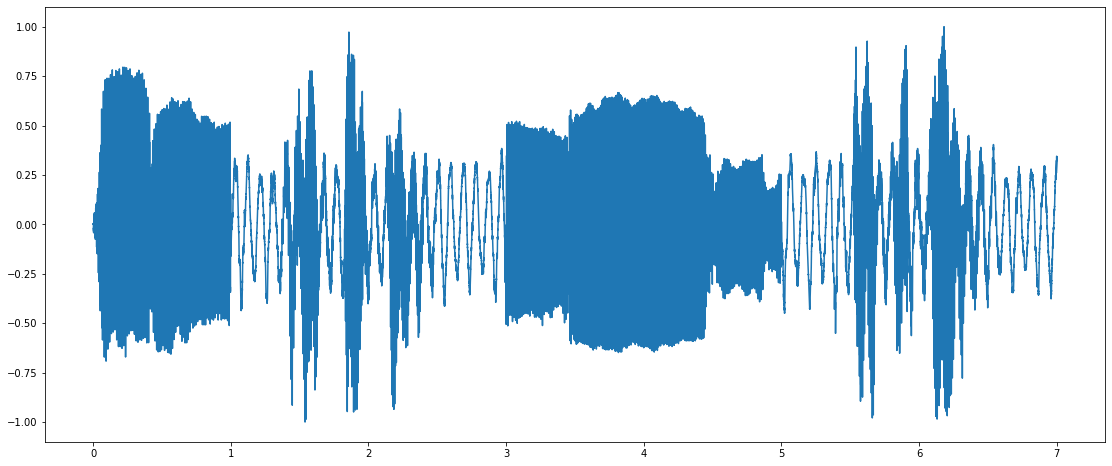

Banyak Data :  112003 
SR (titik/detik) :  16000 
Waktu (detik) :  7.0001875


In [3]:
DataAudio = load_wav("E:/Perkuliahan/Semester 5/Jawaban Tugas/Kapita Selekta/UTS Kapsel/speech_music_sample.wav")

print(DataAudio[1])
Audio = mapping(np.array(DataAudio[1], dtype=np.float64), -1, 1)
SR = DataAudio[2]
T = np.linspace(0, len(Audio)/SR, len(Audio))

print(len(Audio)/SR)
plt.figure(figsize = (19, 8))
plt.plot(T, Audio)
plt.show()
print("Banyak Data : ", len(Audio), "\nSR (titik/detik) : ", SR, "\nWaktu (detik) : ", T[-1])

In [4]:
import IPython.display as ipd
ipd.Audio(Audio, rate = SR)

### Dengan framing

In [5]:
# Framing dilakukan dengan interval waktu 0.025 sekon
# Step = Banyak Data/(waktu/0.025)
# Step = 401.0107 (diambil 402 sekon untuk mengatasi ketimpangan jumlah data di window terakhir)
# Interval dipilih 410 untuk membuat overlap antar window untuk mencegah kehilangan informasi

DataFraming = framing(Audio, 410, 402)
print("Banyak Window = ", len(DataFraming))
print("Banyak elemen window = ", len(DataFraming[1]))
print("Banyak elemen window terakhir = ", len(DataFraming[-1]))
print("Jumlah Frame dalam 1 detik = ", 1/0.025)
print("Bukti bahwa 1 detik = 40 frame adalah : Banyak Window/Jumlah Frame dalam 1 detik harus sama dengan 7 = ", len(DataFraming)/40)

Banyak Window =  279
Banyak elemen window =  410
Banyak elemen window terakhir =  247
Jumlah Frame dalam 1 detik =  40.0
Bukti bahwa 1 detik = 40 frame adalah : Banyak Window/Jumlah Frame dalam 1 detik harus sama dengan 7 =  6.975


##### Terbukti bahwa 1 detik terdiri atas 40 frame dengan aproksimasi $6.975\approx7$

### A. Analysis Time Domain

#### 1. Energy dan Power (Energi Ternormalisasi)

##### Energi per Frame
##### $E_{f} = \displaystyle\sum_{n = 0}^{N} |x_{f}(n)|^{2}$

##### Energi ternormalisasi
##### $E_{f} = (\frac{1}{N})\displaystyle\sum_{n = 0}^{N} |x_{f}(n)|^{2}$

##### dengan N panjang tiap window

In [6]:
Energy = sound_energy(Audio, 410, 402)
Sound_energy = Energy[0]
Sound_power = Energy[1]
t_E = np.linspace(0, T[-1], len(Sound_energy))

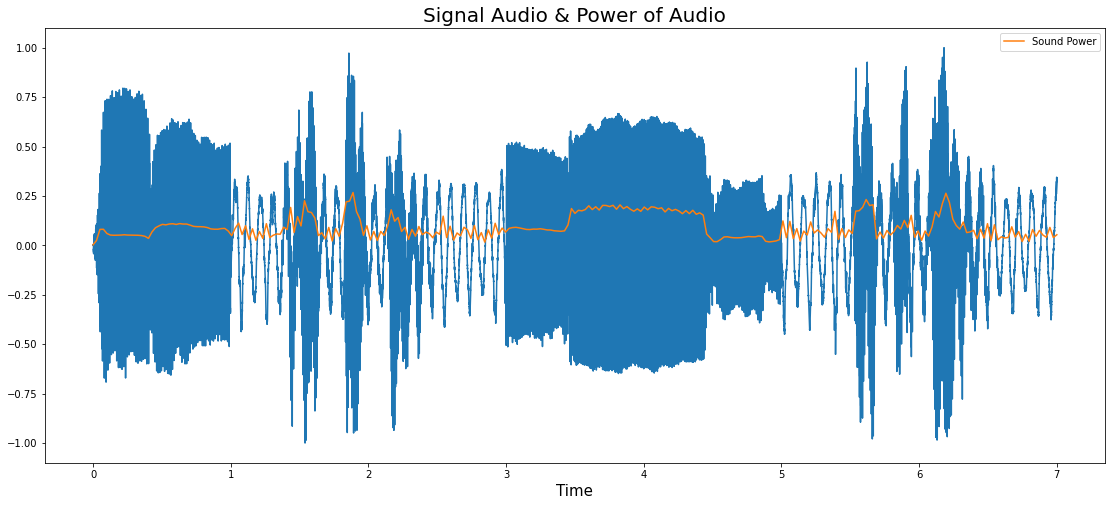

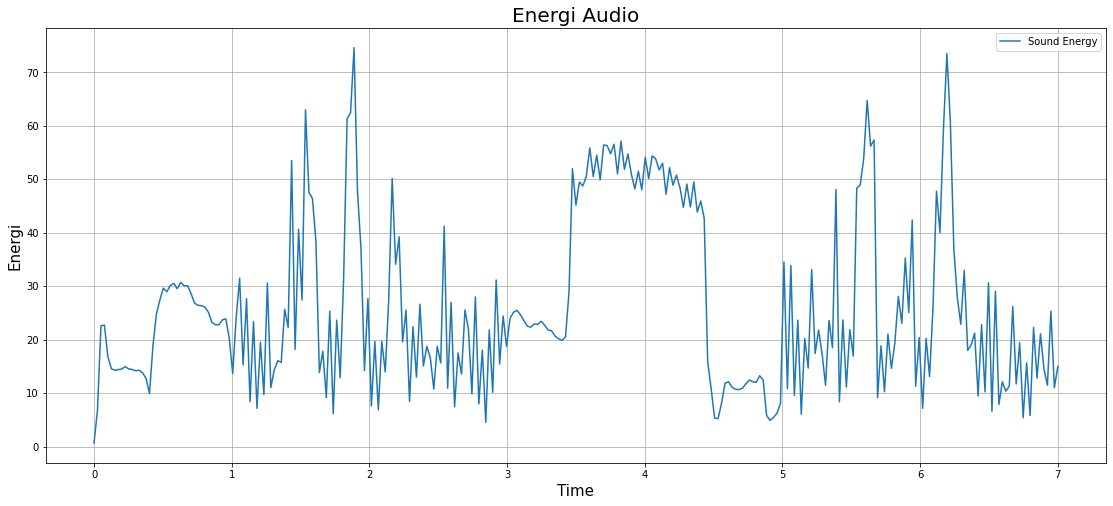

In [7]:
plt.figure(figsize = (19, 8))
plt.plot(T, Audio)
plt.plot(t_E, Sound_power, label = 'Sound Power')
plt.title("Signal Audio & Power of Audio", fontsize = 20); plt.xlabel("Time", fontsize = 15)
plt.legend()
plt.plot()
plt.show()

plt.figure(figsize = (19, 8))
plt.title("Energi Audio", fontsize = 20); plt.xlabel("Time", fontsize = 15); plt.ylabel("Energi", fontsize =15)
plt.plot(t_E, Sound_energy, label = 'Sound Energy')
plt.legend()
plt.plot()
plt.grid()
plt.show()


In [8]:
print("Jumlah titik energy = ", len(Sound_energy), "\nJumlah titik Power = ", len(Sound_power))

Jumlah titik energy =  279 
Jumlah titik Power =  279


In [9]:
dataP2 = {"Power suara orang1": Sound_power[41:121], "Power terompet2" : Sound_power[121:201], "Power suara orang2" : Sound_power[199:280]}
dfP2 = pd.DataFrame(dataP2)

dataP1 = {"Power terompet1" : Sound_power[0:41]}
dfP1 = pd.DataFrame(dataP1)

print(dfP1.describe())
print('\n', dfP2.describe())


       Power terompet1
count        41.000000
mean          0.074855
std           0.026839
min           0.002339
25%           0.051601
50%           0.081556
75%           0.096160
max           0.110030

        Power suara orang1  Power terompet2  Power suara orang2
count           80.000000        80.000000           80.000000
mean             0.085627         0.117852            0.086439
std              0.052827         0.066411            0.055951
min              0.016211         0.017488            0.019299
25%              0.049904         0.044573            0.041717
50%              0.070418         0.113488            0.072816
75%              0.099479         0.181390            0.105559
max              0.267395         0.204754            0.263500


Text(0.5, 0, 'Class')

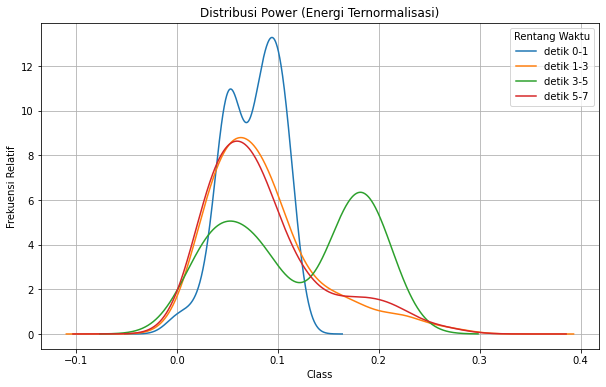

In [10]:
plt.figure(figsize = (10, 6))
plt.title("Distribusi Power (Energi Ternormalisasi)")
dfP1['Power terompet1'].plot(kind = 'kde')
dfP2['Power suara orang1'].plot(kind = 'kde')
dfP2['Power terompet2'].plot(kind = 'kde')
dfP2['Power suara orang2'].plot(kind = 'kde')
plt.legend(['detik 0-1', 'detik 1-3', 'detik 3-5', 'detik 5-7'], title = 'Rentang Waktu')
plt.ylabel('Frekuensi Relatif')
plt.grid()
plt.xlabel('Class')

#### 2. Zero Crossing Rate

In [11]:
import librosa, librosa.display

Audio_zcr = librosa.feature.zero_crossing_rate(Audio)
t_zcr = np.linspace(0, T[-1], len(Audio_zcr[0]))
print(len(Audio_zcr[0]))


219


In [12]:
ls = [1, 4, 2, 4, 5, 2, 6, 7]
print(ls[0:2])
print(ls[2:4])

[1, 4]
[2, 4]


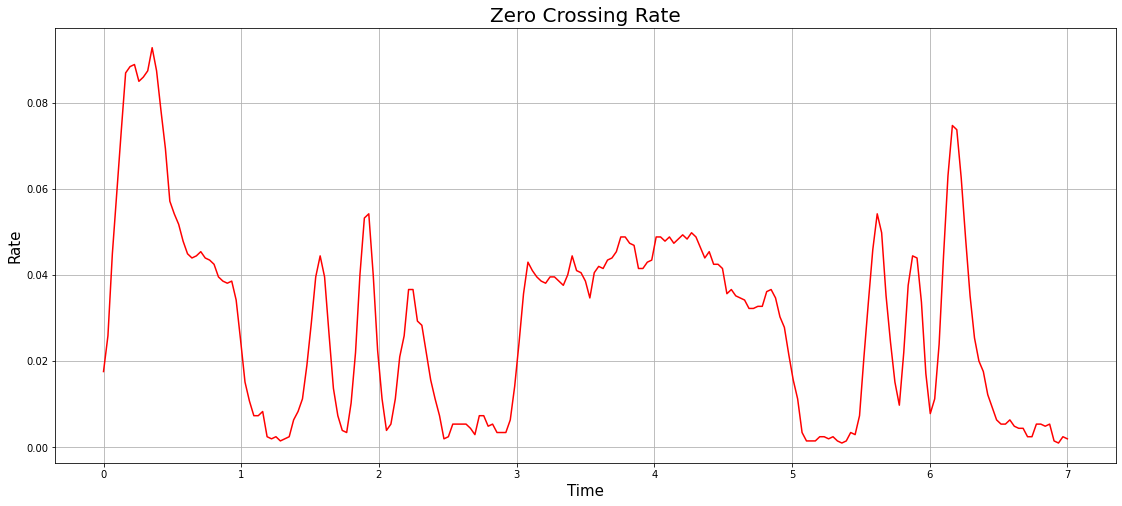

In [13]:
plt.figure(figsize = (19, 8))
plt.plot(t_zcr, Audio_zcr[0], 'red')
plt.title("Zero Crossing Rate", fontsize = 20); plt.xlabel("Time", fontsize = 15); plt.ylabel("Rate", fontsize = 15)
plt.grid()
plt.show()

In [14]:
dataZcr2 = {"Zcr suara orang1": Audio_zcr[0][31:94], "Zcr terompet2" : Audio_zcr[0][93:156], "Zcr suara orang2" : Audio_zcr[0][156:219]}
dfZcr2 = pd.DataFrame(dataZcr2)
dataZcr1 = {"Zcr terompet1" : Audio_zcr[0][0:31]}
dfZcr1 = pd.DataFrame(dataZcr1)

print(dfZcr1.describe())
print('\n', dfZcr2.describe())


       Zcr terompet1
count      31.000000
mean        0.057397
std         0.021853
min         0.017578
25%         0.042969
50%         0.047852
75%         0.081543
max         0.092773

        Zcr suara orang1  Zcr terompet2  Zcr suara orang2
count         63.000000      63.000000         63.000000
mean           0.014842       0.040140          0.018229
std            0.013969       0.007165          0.020146
min            0.001465       0.014160          0.000977
25%            0.004639       0.035889          0.002686
50%            0.008301       0.041016          0.007812
75%            0.022217       0.045410          0.029541
max            0.054199       0.049805          0.074707


Text(0.5, 0, 'Class')

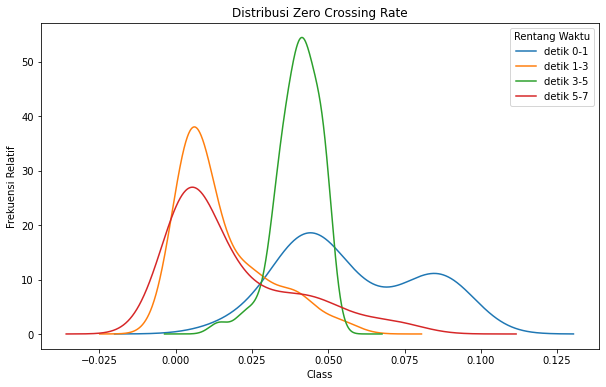

In [15]:
plt.figure(figsize = (10, 6))
plt.title("Distribusi Zero Crossing Rate")
dfZcr1['Zcr terompet1'].plot(kind = 'kde')
dfZcr2['Zcr suara orang1'].plot(kind = 'kde')
dfZcr2['Zcr terompet2'].plot(kind = 'kde')
dfZcr2['Zcr suara orang2'].plot(kind = 'kde')
plt.legend(['detik 0-1', 'detik 1-3', 'detik 3-5', 'detik 5-7'], title = 'Rentang Waktu')
plt.ylabel('Frekuensi Relatif')
plt.xlabel('Class')

#### 3. Entropy of Energy


##### $e_{j} = \frac {E_{subFrame}}{E_{shortFrame}}$

##### $H(i) = - \displaystyle\sum_{j = 1}^{K} e_{j}.log_{2}(e_{j})$

In [16]:
energy_subframe = sound_energy(Audio, 144, 134)
Sound_entropy = entropy(energy_subframe[0], Sound_energy[:278])
t_entropy = np.linspace(0, T[-1], len(Sound_entropy))
print("Panjang Energi Subframe = ", len(energy_subframe[0]))

Panjang Energi Subframe =  836


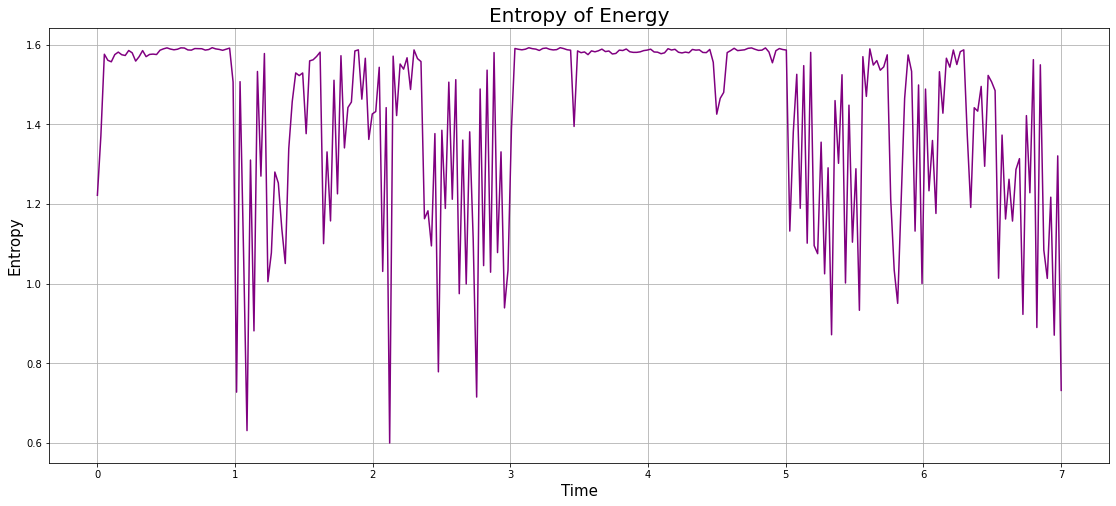

In [17]:
plt.figure(figsize = (19, 8))
plt.plot(t_entropy, Sound_entropy, 'purple')
plt.title("Entropy of Energy", fontsize = 20); plt.xlabel("Time", fontsize = 15); plt.ylabel("Entropy", fontsize = 15)
plt.grid()
plt.show()

In [18]:
print(len(Sound_entropy))

278


In [19]:
dataentropi2 = {"Entropi suara orang1": Sound_entropy[39:119], "Entropi terompet2" : Sound_entropy[118:198], "Entropi suara orang2" : Sound_entropy[198:278]}
dfe2 = pd.DataFrame(dataentropi2)
dataentropi1 = {"Entropi terompet1" : Sound_entropy[0:39]}
dfe1 = pd.DataFrame(dataentropi1)

print(dfe1.describe())
print('\n', dfe2.describe())


       Entropi terompet1
count          39.000000
mean            1.567241
std             0.066761
min             1.221691
25%             1.574834
50%             1.585730
75%             1.588851
max             1.592086

        Entropi suara orang1  Entropi terompet2  Entropi suara orang2
count             80.000000          80.000000             80.000000
mean               1.310763           1.567770              1.319497
std                0.257042           0.072022              0.227441
min                0.599970           1.033038              0.732070
25%                1.109776           1.580385              1.150691
50%                1.378735           1.585068              1.365840
75%                1.529623           1.588049              1.532034
max                1.586725           1.592068              1.589118


Text(0.5, 0, 'Class')

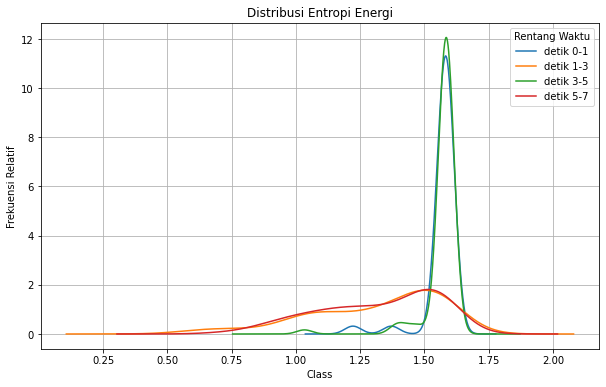

In [20]:
plt.figure(figsize = (10, 6))
plt.title("Distribusi Entropi Energi")
dfe1['Entropi terompet1'].plot(kind = 'kde')
dfe2['Entropi suara orang1'].plot(kind = 'kde')
dfe2['Entropi terompet2'].plot(kind = 'kde')
dfe2['Entropi suara orang2'].plot(kind = 'kde')
plt.legend(['detik 0-1', 'detik 1-3', 'detik 3-5', 'detik 5-7'], title = 'Rentang Waktu')
plt.ylabel('Frekuensi Relatif')
plt.grid()
plt.xlabel('Class')

#### B. Analysis Frequency Domain

#### 1. Fourier Transform

In [21]:
### Discrete Fourier Transform

DFT = fourier_transform(DataFraming, SR)
mag, frek = DFT[0], DFT[1]

print("Banyak Frame = ", len(mag))

print(type(DataFraming[0]))

Banyak Frame =  279
<class 'numpy.ndarray'>


##### Sampel DFT Dari Beberapa Frame

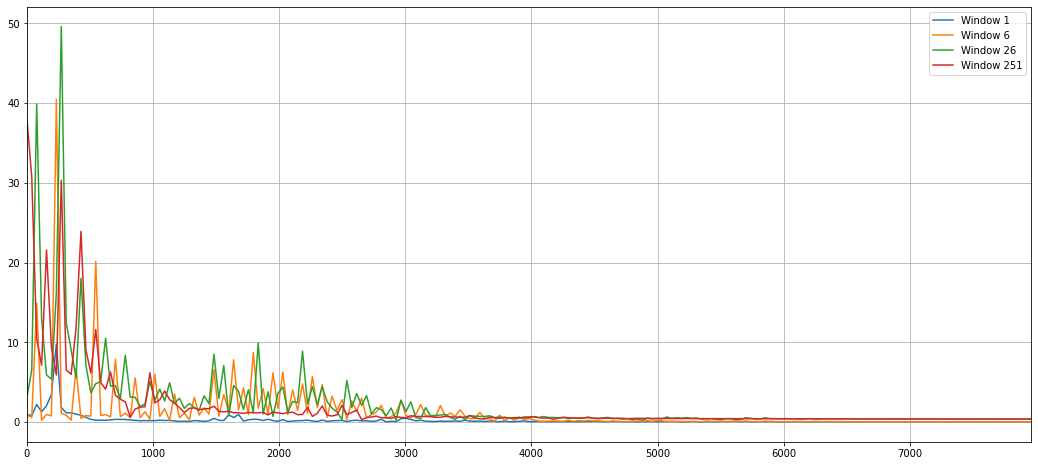

In [22]:
plt.figure(figsize = (18, 8))
plt.plot(frek[0], mag[0], label = 'Window 1')
plt.plot(frek[5], mag[5], label = 'Window 6')
plt.plot(frek[25], mag[25], label = 'Window 26')
plt.plot(frek[25], mag[250], label = 'Window 251')
plt.grid()
plt.xlim(0, frek[0][-1])
plt.legend()
plt.show()

#### 2. Spectral Centroid & Spread

In [23]:
Spectral_Centroid = C(mag, frek)


Text(0.5, 0.98, 'Plot Spectral Centroid')

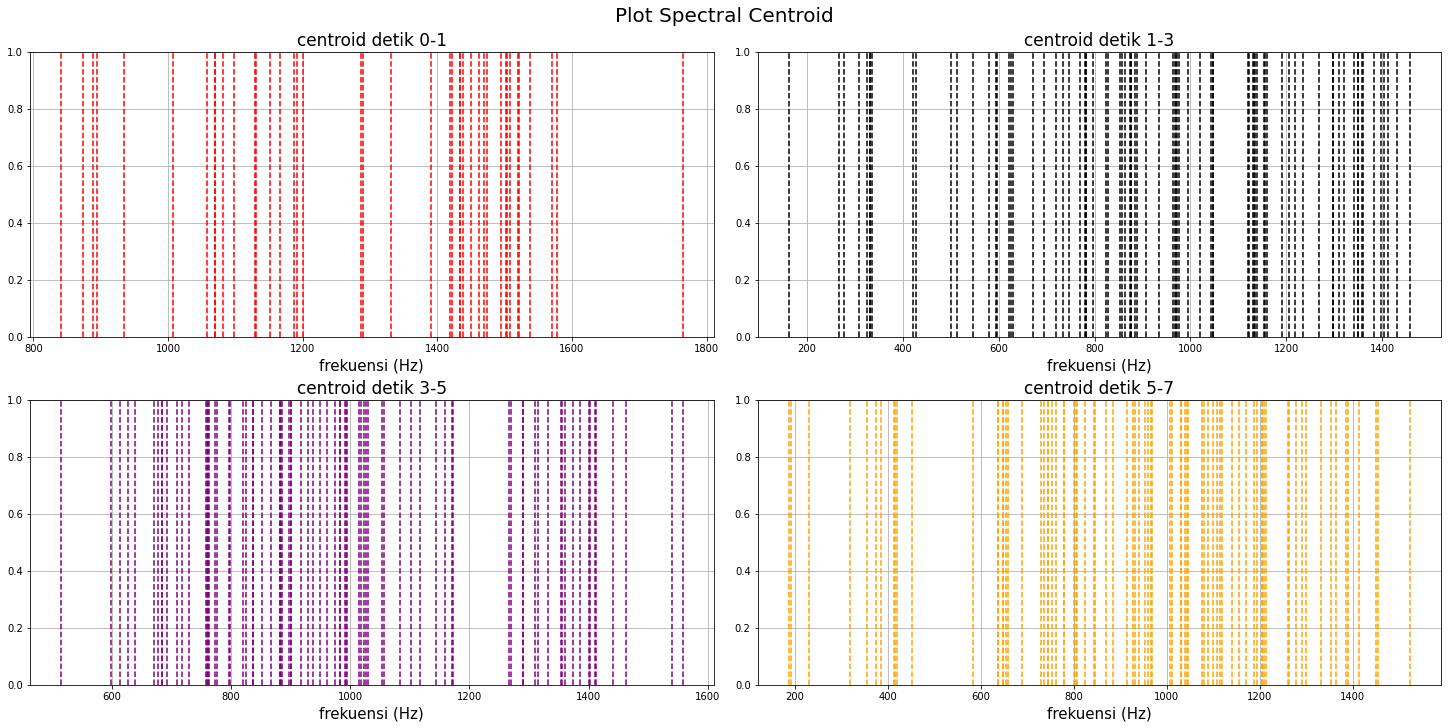

In [24]:
# Plot fft
fig = plt.figure(figsize=(20, 10), constrained_layout=True)
spec = fig.add_gridspec(nrows = 2, ncols = 2)

ax00 = fig.add_subplot(spec[0])
for i in Spectral_Centroid[0:41]:
    ax00.axvline(i, ls = '--', color = 'red')
ax00.grid()
ax00.set_ylim(0)
ax00.set_title("centroid detik 0-1", fontsize = 17)
ax00.set_xlabel("frekuensi (Hz)", fontsize = 15)

ax01 = fig.add_subplot(spec[1])
for i in Spectral_Centroid[41:121]:
    ax01.axvline(i, ls = '--', color = 'black')
ax01.grid()
ax01.set_ylim(0)
ax01.set_title("centroid detik 1-3", fontsize = 17)
ax01.set_xlabel("frekuensi (Hz)", fontsize = 15)

ax10 = fig.add_subplot(spec[2])
for i in Spectral_Centroid[121:201]:
    ax10.axvline(i, ls = '--', color = 'purple')
ax10.grid()
ax10.set_ylim(0)
ax10.set_title("centroid detik 3-5", fontsize = 17)
ax10.set_xlabel("frekuensi (Hz)", fontsize = 15)

ax11 = fig.add_subplot(spec[3])
for i in Spectral_Centroid[199:280]:
    ax11.axvline(i, ls = '--', color = 'orange')
ax11.grid()
ax11.set_ylim(0)
ax11.set_title("centroid detik 5-7", fontsize = 17)
ax11.set_xlabel("frekuensi (Hz)", fontsize = 15)

fig.suptitle('Plot Spectral Centroid', fontsize=20)


In [25]:
def arraytolist(data):
    ls = [i for i in data]
    return ls

SC = arraytolist(Spectral_Centroid)
print(len(SC))

279


###### Spectral centroid terdiri dari 279 jumlah data
###### Artinya Tiap detik memuat 40 data (untuk detik terakhir hanya 39 data)
###### Untuk melihat sebaran data, dapat dilihat dengan membuat distribusi normalnya
###### jika ingin dilihat perdetik, maka harus diambil 40 data secara sekuensial

In [26]:
data1 = {"suara orang1": SC[41:121], "terompet2" : SC[121:201], "suara orang2" : SC[199:280]}
dataSC1 = pd.DataFrame(data1)

data2 = {"terompet1" : SC[0:41]}
dataSC2 = pd.DataFrame(data2)

In [27]:
print(dataSC1.describe())
print('\n', dataSC2.describe())

       suara orang1    terompet2  suara orang2
count     80.000000    80.000000     80.000000
mean     914.698263  1001.474763    922.098564
std      338.289128   261.195005    327.600273
min      162.570238   515.525266    186.277663
25%      689.147961   791.465890    734.254372
50%      921.020875   968.187257    955.897908
75%     1167.121565  1196.310597   1174.233936
max     1457.944029  1557.576371   1523.471348

          terompet1
count    41.000000
mean   1287.156805
std     234.911397
min     841.180034
25%    1098.174264
50%    1330.801993
75%    1474.055814
max    1764.326106


Text(0.5, 0, 'Frekuensi Audio')

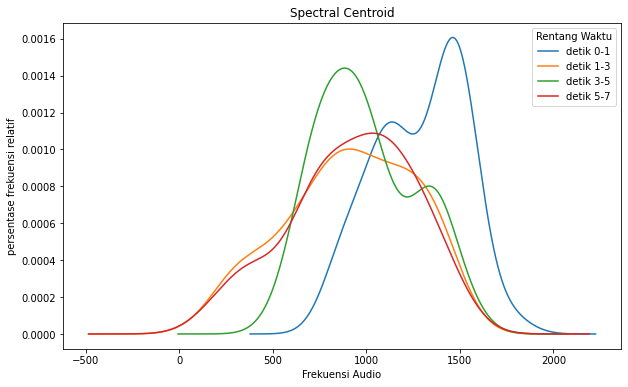

In [28]:
plt.figure(figsize = (10, 6))
plt.title("Spectral Centroid")
dataSC2['terompet1'].plot(kind = 'kde')
dataSC1['suara orang1'].plot(kind = 'kde')
dataSC1['terompet2'].plot(kind = 'kde')
dataSC1['suara orang2'].plot(kind = 'kde')
plt.legend(['detik 0-1', 'detik 1-3', 'detik 3-5', 'detik 5-7'], title = 'Rentang Waktu')
plt.ylabel('persentase frekuensi relatif')
plt.xlabel('Frekuensi Audio')

In [29]:
Spread = SpectralSpread(SC, mag, frek)


In [30]:
dataS1 = {"suara orang1": Spread[41:121], "terompet2" : Spread[121:201], "suara orang2" : Spread[199:280]}
dfS1 = pd.DataFrame(dataS1)

dataS2 = {"terompet1" : Spread[0:41]}
dfS2 = pd.DataFrame(dataS2)

In [31]:
print(dfS1.describe())
print('\n', dfS2.describe())

       suara orang1    terompet2  suara orang2
count     80.000000    80.000000     80.000000
mean    1567.877052  1495.525802   1569.776835
std      371.566916   304.731738    359.802083
min      685.415040   911.273638    668.924227
25%     1306.037222  1221.880352   1327.364552
50%     1660.953738  1508.475123   1668.633307
75%     1857.666875  1762.309284   1843.557303
max     2025.951684  2022.991147   2040.354119

          terompet1
count    41.000000
mean   1378.133230
std     233.352785
min    1059.282217
25%    1177.696376
50%    1322.762530
75%    1543.587122
max    1849.299361


Text(0.5, 0, 'Frekuensi Audio')

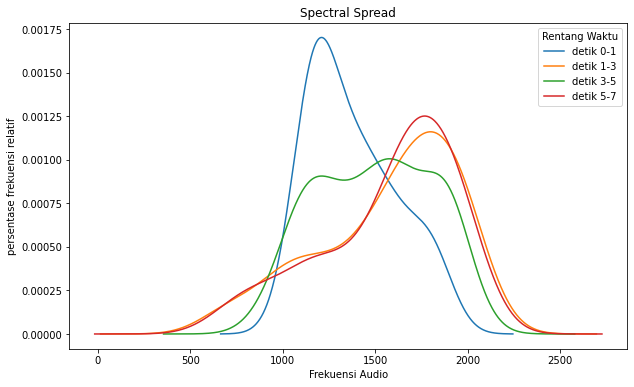

In [32]:
plt.figure(figsize = (10, 6))
plt.title("Spectral Spread")
dfS2['terompet1'].plot(kind = 'kde')
dfS1['suara orang1'].plot(kind = 'kde')
dfS1['terompet2'].plot(kind = 'kde')
dfS1['suara orang2'].plot(kind = 'kde')
plt.legend(['detik 0-1', 'detik 1-3', 'detik 3-5', 'detik 5-7'], title = 'Rentang Waktu')
plt.ylabel('persentase frekuensi relatif')
plt.xlabel('Frekuensi Audio')

#### 3. MFCC Spectrogram 

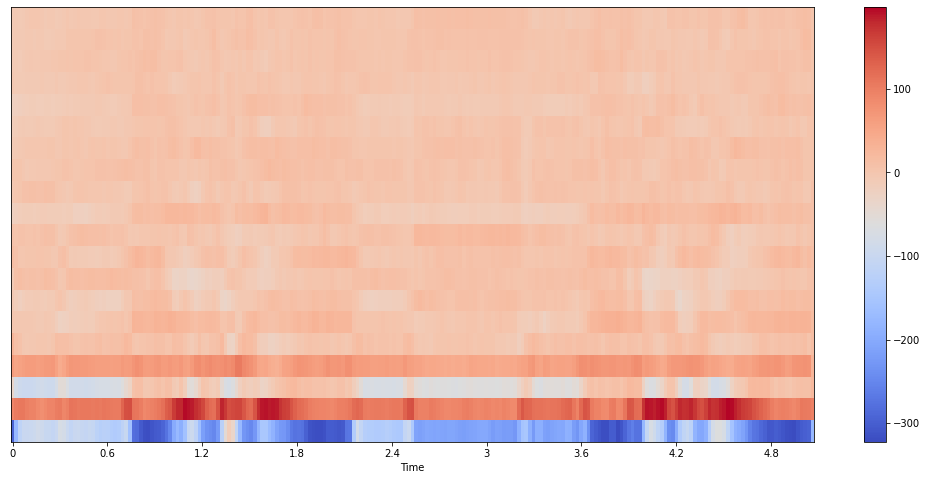

In [33]:
Audio_mfcc = librosa.feature.mfcc(y = Audio, sr = SR)

plt.figure(figsize = (18, 8))
img1 = librosa.display.specshow(Audio_mfcc, x_axis='time')
plt.colorbar(img1)


#### 4. Mel Spectrogram

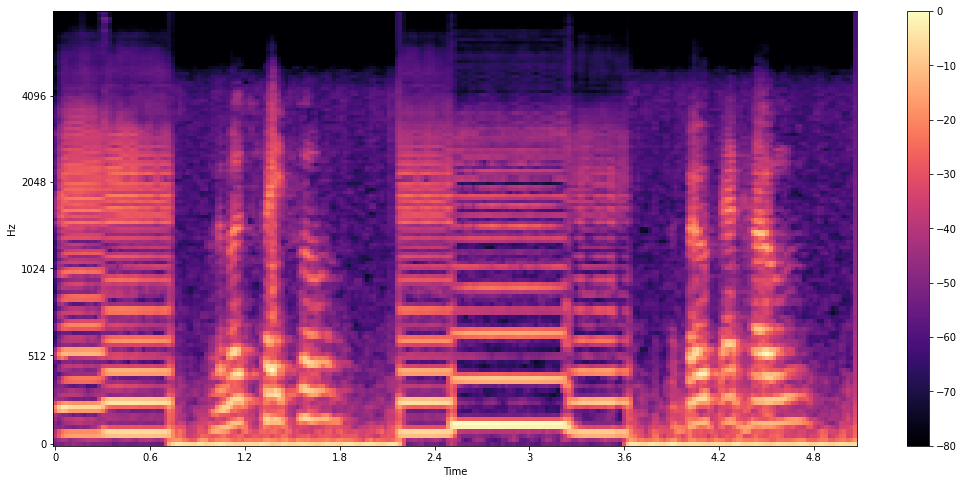

In [34]:
plt.figure(figsize = (18, 8))
Audio_mel = librosa.feature.melspectrogram(y = Audio, sr = SR)
ms_Audio = librosa.display.specshow(librosa.power_to_db(Audio_mel, ref=np.max),
                               x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(ms_Audio)

#### Hasil Eksperimen

In [35]:
sampel1 = arraytolist(mag[5]).index(np.max(arraytolist(mag[5])))
sampel2 = arraytolist(mag[60]).index(np.max(arraytolist(mag[60])))
sampel3 = arraytolist(mag[100]).index(np.max(arraytolist(mag[100])))
sampel4 = arraytolist(mag[150]).index(np.max(arraytolist(mag[150])))


In [36]:
print("Koefisien Max Fourier Frame ke 5 : ", mag[5][sampel1], "Frek Dominan : ", frek[5][sampel1])
print("Koefisien Max Fourier Frame ke 60 : ", mag[60][sampel2], "Frek Dominan : ", frek[60][sampel2])
print("Koefisien Max Fourier Frame ke 100 : ", mag[100][sampel3], "Frek Dominan : ", frek[100][sampel3])
print("Koefisien Max Fourier Frame ke 150 : ", mag[150][sampel4], "Frek Dominan : ", frek[105][sampel4])


Koefisien Max Fourier Frame ke 5 :  40.47056475304109 Frek Dominan :  234.14634146341461
Koefisien Max Fourier Frame ke 60 :  39.46875058054681 Frek Dominan :  273.1707317073171
Koefisien Max Fourier Frame ke 100 :  40.465111182819996 Frek Dominan :  39.02439024390244
Koefisien Max Fourier Frame ke 150 :  82.37051729351474 Frek Dominan :  117.07317073170731


### Analisis & Kesimpulan

##### Dari hasil pencarian ciri audio diperoleh bahwa audio suara dan suara alat musik (diduga dari terompet) dari data terlihat sangat jelas. Suara alat musik  dibunyikan selama 1 detik pertama kemudian 2 detik berikutnya terdapat suara seseorang, dan 2 detik berikutnya dinyalakan kembali artificial tone dan 2 detik terakhir terdengar suara seseorang. Sebelum melakukan analisis, dilakukan proses framing pada data audio. Framing dilakukan dengan interval waktu 0.025 sekon, dengan overlap sebanya 8 sampel data (interval - step = 410 - 402 = 8). 

##### Pada parameter zero crossing rate (zcr), dapat dilihat dari kurva distribusinya bahwa rata-rata nilai zcr suara alat musik lebih besar dari pada zcr suara manusia. Hal tersebut menunjukkan bahwa frekuensi yang dihasilkan oleh suara alat musik lebih besar dibanding suara manusia. Namun dari grafik  zcr vs time menunjukkan bahwa nilai zcr suara manusia cenderung naik turun yang mengindikasikan bahwa suara manusia menghasilkan perubahan frekuensi selama proses perekaman.  

##### Dari frekuensi dan spektrum terlihat jelas bahwa energi dan entropy energi stabil pada suara alat musik (terompet) namun terlihat bergejolak di suara manusia. Hal itu ditunjukkan dari kurva distribusi, dimana distribusi entropi energi pada suara alat musik (terompet) cenderung lebih ramping dibandingkan distribusi entropy energi suara manusia yang tersebar cukup merata. Nilai entropi energi dari suara alat musik (terompet) juga lebih besar dibandingkan nilai entropi energi dari suara manusia. Serta nilai standar deviasi yang kecil dari entropi energi suara alat musik (terompet) menunjukkan bahwa frekuensi yang dihasilkan oleh suara alat musik (terompet) cenderung lebih stabil dibanding standar deviasi dari entropi energi suara manusia yang cenderung besar yang membuat kurva distribusinya melebar.  

##### Setelah analisis pada domain waktu selesai, selanjutnya sinyal di transformasi fourier. Transformasi fourier dilakukan pada setiap semua frame. Setelah mendapatkan hasil transformasi, selanjutnya masing-masing data dicari nilai pusat spektrumnya (spektral centroid). Perhitungan nilai pusat spektrum ini seperti mencari titik berat benda. Dari hasil distribusi, terlihat bahwa spektral centroid  dari suara orang saat pertama kali dan kedua kali saling tumpang tindih, dan grafiknya hampir cocok. Hal tersebut menunjukkan suara yang dihasilkan orang yang berbicara tersebut memiliki pusat frekuensi yang hampir identik pada saat pertama dan pengulangan keduanya, yakni di 914 Hz dan 922 Hz secara berturut-turut. Sedangkan frekuensi musik yang diduga dari terompet mengalami penurunan pada iterasi ke duanya. Dimana frekuensinya secara berturut-turut 1287 Hz dan 1001 Hz. Hal ini memang menunjukkan bahwa hasil rekaman audio pada bunyi alat musik (terompet) terdengar menurun di iterasi ke-duanya. Hasil analisis ini memvalidasi hasil perhitungan zcr dimana pada iterasi kedua suara alat musik memang mengalami penurunan. 

##### Terakhir adalah parameter sebaran spektrum (spectral spread). Parameter ini digunakan untuk menghitung sebaran spektrum dari suara. Atau dalam artian lainnya adalah lebar pita frekuensi yang ada pada masing-masing komponen suara pada audio. Dari hasil distribusi diperoleh bahwa spektral spread  dari suara orang saat pertama kali dan kedua kali saling tumpang tindih, dan grafiknya hampir cocok. Hal tersebut menunjukkan suara yang dihasilkan orang yang berbicara tersebut memiliki bandwidth frekuensi yang hampir identik pada saat pertama dan pengulangan keduanya, yakni di 1567 Hz dan 1569 Hz secara berturut-turut. Sedangkan bandwidth frekuensi alat musik yang diduga dari terompet mengalami kenaikan pada iterasi ke duanya. Dimana frekuensinya secara berturut-turut 1378 Hz dan 1495 Hz. Hal ini memang memvalidasi hasil analisis pada domain waktu, dimana parameter energi entropi (grafik entropy of energy vs time) pada suara orang bervariasi, sedangkan pada suara alat musik (terompet) cenderung relatif tetap. 

##### Dapat disimpulkan dari analisis di atas, bahwa suara manusia cenderung memiliki variasi frekuensi yang beragam setiap kosa kata yang dikeluarkan memiliki ciri frekuensinya sendiri. Hal tersebut dibuktikan oleh parameter spectral centroid dimana bandwidth frekuensi suara manusia lebih besar dibandingkan komponen suara dari alat musik (terompet). Asumsi tersebut juga didukung oleh hasil perhitungan entropi energi, dimana kurva distribusi dari komponen suara alat musik membentuk lebih lancip dibandingkan suara manusia yang cenderung menyebar. Hal itu dapat dibuktikan dengan melihat bentuk kurva distribusi dan standar deviasinya. Selain itu, hasil plot mel spektrum juga menunjukkan dengan jelas gambaran suara orang dengan suara dari alat musik (terompet). Dimana spektrogram mel pada suara terompet membentuk kotak yang berarti frekuensinya cenderung tetap dibandingkan frekuensi dari suara manusia yang cenderung fluktuatif.

#### Referensi

###### GiannaKopoulos, T,. & Pikrakis, A. 2014. Introduction to Audio Analysis: A Matlab Approach
###### https://www.youtube.com/watch?v=im_2ckt1wyo
###### Analysis of Zero Crossing Rates of Different Music Genre Tracks, https://www.analyticsvidhya.com/blog/2022/01/analysis-of-zero-crossing-rates-of-different-music-genre-tracks/
###### https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html
###### https://librosa.org/doc/main/index.html
###### https://www.statology.org/pandas-plot-distribution-of-column/